In [2]:
import numpy as np
import xlrd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from google.colab import files 
uploaded = files.upload()


Saving entrada.xlsx to entrada.xlsx


A funcao 'plota' produz um gráfico da estrutura definida pela matriz de nos N 
e pela incidencia Inc.

Sugestao de uso:

from funcoesTermosol import plota
plota(N,Inc)
-------------------------------------------------------------------------------
A funcao 'importa' retorna o numero de nos [nn], a matriz dos nos [N], o numero
de membros [nm], a matriz de incidencia [Inc], o numero de cargas [nc], o vetor
carregamento [F], o numero de restricoes [nr] e o vetor de restricoes [R] 
contidos no arquivo de entrada.

Sugestao de uso:
    
from funcoesTermosol import importa
[nn,N,nm,Inc,nc,F,nr,R] = importa('entrada.xlsx')
-------------------------------------------------------------------------------
A funcao 'geraSaida' cria um arquivo nome.txt contendo as reacoes de apoio Ft, 
deslocamentos Ut, deformacoes Epsi, forcas Fi e tensoes Ti internas. 
As entradas devem ser vetores coluna.

Sugestao de uso:
    
from funcoesTermosol import geraSaida
geraSaida(nome,Ft,Ut,Epsi,Fi,Ti)
-------------------------------------------------------------------------------



In [4]:
def plota(N,Inc):
    # Numero de membros
    nm = len(Inc[:,0])
    
    import matplotlib as mpl
    import matplotlib.pyplot as plt

#    plt.show()
    fig = plt.figure()
    # Passa por todos os membros
    for i in range(nm):
        
        # encontra no inicial [n1] e final [n2] 
        n1 = int(Inc[i,0])
        n2 = int(Inc[i,1])        

        plt.plot([N[0,n1-1],N[0,n2-1]],[N[1,n1-1],N[1,n2-1]],color='r',linewidth=3)


    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [5]:
def importa(entradaNome):

    
    arquivo = xlrd.open_workbook(entradaNome)
    
    ################################################## Ler os nos
    nos = arquivo.sheet_by_name('Nos')
    
    # Numero de nos
    nn = int(nos.cell(1,3).value)
                 
    # Matriz dos nós
    N = np.zeros((2,nn))
    
    for c in range(nn):
        N[0,c] = nos.cell(c+1,0).value
        N[1,c] = nos.cell(c+1,1).value
    
    ################################################## Ler a incidencia
    incid = arquivo.sheet_by_name('Incidencia')
    
    # Numero de membros
    nm = int(incid.cell(1,5).value)
                 
    # Matriz de incidencia
    Inc = np.zeros((nm,4))
    
    for c in range(nm):
        Inc[c,0] = int(incid.cell(c+1,0).value)
        Inc[c,1] = int(incid.cell(c+1,1).value)
        Inc[c,2] = incid.cell(c+1,2).value
        Inc[c,3] = incid.cell(c+1,3).value
    
    ################################################## Ler as cargas
    carg = arquivo.sheet_by_name('Carregamento')
    
    # Numero de cargas
    nc = int(carg.cell(1,4).value)
                 
    # Vetor carregamento
    F = np.zeros((nn*2,1))
    
    for c in range(nc):
        no = carg.cell(c+1,0).value
        xouy = carg.cell(c+1,1).value
        GDL = int(no*2-(2-xouy)) 
        F[GDL-1,0] = carg.cell(c+1,2).value
         
    ################################################## Ler restricoes
    restr = arquivo.sheet_by_name('Restricao')
    
    # Numero de restricoes
    nr = int(restr.cell(1,3).value)
                 
    # Vetor com os graus de liberdade restritos
    R = np.zeros((nr,1))
    
    for c in range(nr):
        no = restr.cell(c+1,0).value
        xouy = restr.cell(c+1,1).value
        GDL = no*2-(2-xouy) 
        R[c,0] = GDL-1


    return nn,N,nm,Inc,nc,F,nr,R


In [18]:
def geraSaida(nome,Ft,Ut,Epsi,Fi,Ti):
    nome = nome + '.txt'
    f = open("saida.txt","w+")
    f.write('Reacoes de apoio [N]\n')
    f.write(str(Ft))
    f.write('\n\nDeslocamentos [m]\n')
    f.write(str(Ut))
    f.write('\n\nDeformacoes []\n')
    f.write(str(Epsi))
    f.write('\n\nForcas internas [N]\n')
    f.write(str(Fi))
    f.write('\n\nTensoes internas [Pa]\n')
    f.write(str(Ti))
    f.close()

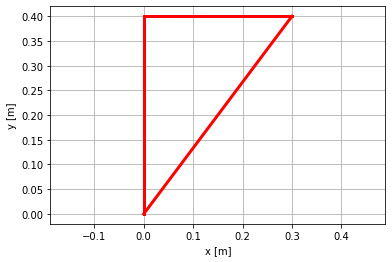

In [19]:
nn,N,nm,Inc,nc,F,nr,R = importa('entrada.xlsx')
plota(N,Inc)

In [20]:
importa('entrada.xlsx')

(3, array([[0. , 0. , 0.3],
        [0. , 0.4, 0.4]]), 3, array([[1.0e+00, 2.0e+00, 2.1e+11, 2.0e-04],
        [2.0e+00, 3.0e+00, 2.1e+11, 2.0e-04],
        [3.0e+00, 1.0e+00, 2.1e+11, 2.0e-04]]), 2, array([[   0.],
        [   0.],
        [   0.],
        [   0.],
        [ 150.],
        [-100.]]), 3, array([[0.],
        [2.],
        [3.]]))

In [21]:
N_1 = np.transpose(N)
def get_angles_lenghts(N):
  angs = np.zeros((len(N[:,0]),len(N[0,:])))
  Ls = []
  for i in range(len(N[:,0])):
    if i < len(N[:,0]) -1:
      L = np.sqrt((N[i+1,0]-N[i,0])**2 +(N[i+1,1]-N[i,1])**2)
      Ls.append(L)
      angs[i,0] = (N[i+1,0]-N[i,0])/L
      angs[i,1] = (N[i+1,1]-N[i,1])/L
    else:
      L = np.sqrt((N[0,0]-N[i,0])**2 +(N[0,1]-N[i,1])**2)
      Ls.append(L)
      angs[i,0] = (N[0,0]-N[i,0])/L
      angs[i,1] = (N[0,1]-N[i,1])/L
  return Ls,angs
Ls,angs = get_angles_lenghts(N_1)

In [22]:
def fill_matrix(E,A,l,c,s):
  M = E*A/l * np.array([[c**2,c*s,-c**2,-c*s],
                [c*s,s**2,-c*s,-s**2],
                [-c**2,-c*s,c**2,c*s],
                [-c*s,-s**2,c*s,s**2]])
  return M

In [23]:
def get_matriz_elemento(N):
  lista = []
  for i in range(len(N[:,0])):
    k = np.zeros((4,4))
    c = angs[i,0]
    s = angs[i,1]
    M = fill_matrix(Inc[i,2],Inc[i,3],Ls[i],c,s)
    lista.append(M)
  return lista

In [24]:
def get_matriz_global(N,lista):
  matriz_global = np.zeros((2*len(N[:,0]),2*len(N[:,0])))
  for i in range(len(N[:,0])):
      if i == len(N[:,0]) -1:
        N1 = int(Inc[i,0])
        N2= int(Inc[0,0])
      else:
        N1 = int(Inc[i,0])
        N2= int(Inc[i+1,0])
        
      grau1 = 2*N1 - 1
      grau2 = 2*N1 
      grau3 = 2*N2 - 1
      grau4 = 2*N2

      matriz_global[grau1-1:grau2, grau1-1:grau2] += lista[i][0:2, 0:2]
      matriz_global[grau3-1:grau4, grau1-1:grau2] += lista[i][2:4, 0:2]
      matriz_global[grau1-1:grau2, grau3-1:grau4] += lista[i][0:2, 2:4]
      matriz_global[grau3-1:grau4, grau3-1:grau4] += lista[i][2:4, 2:4]
  return matriz_global

In [25]:
N_1 = np.transpose(N)
Ls,angs = get_angles_lenghts(N_1)
get_matriz_global(N_1,get_matriz_elemento(N_1))

array([[ 3.0240e+07,  4.0320e+07,  0.0000e+00,  0.0000e+00, -3.0240e+07,
        -4.0320e+07],
       [ 4.0320e+07,  1.5876e+08,  0.0000e+00, -1.0500e+08, -4.0320e+07,
        -5.3760e+07],
       [ 0.0000e+00,  0.0000e+00,  1.4000e+08,  0.0000e+00, -1.4000e+08,
         0.0000e+00],
       [ 0.0000e+00, -1.0500e+08,  0.0000e+00,  1.0500e+08,  0.0000e+00,
         0.0000e+00],
       [-3.0240e+07, -4.0320e+07, -1.4000e+08,  0.0000e+00,  1.7024e+08,
         4.0320e+07],
       [-4.0320e+07, -5.3760e+07,  0.0000e+00,  0.0000e+00,  4.0320e+07,
         5.3760e+07]])